# BRCA Histological Type Classification

Predicting breast cancer histological subtype (ductal vs. lobular) from multi-omic measurements.

## Workflow
1. Import libraries
2. Load and inspect data
3. Preprocess features
4. PCA transformation (dimensionality reduction)
5. Model training with hyperparameter tuning (Logistic Regression)
6. Evaluation and interpretation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 1. Load and Explore Data

In [4]:
DATA_PATH = 'brca_data_w_subtypes.csv'
TARGET_COLUMN = 'histological.type'

df = pd.read_csv(DATA_PATH)

print('='*80)
print('DATASET OVERVIEW')
print('='*80)
print(f'Dataset shape: {df.shape}')
print(f'Total samples: {len(df):,}')
print(f'Total columns: {len(df.columns):,}')
print(f'Target column: {TARGET_COLUMN}')
print(f'First 5 feature columns: {df.columns[:5].tolist()}')
print(f'Last 5 columns: {df.columns[-5:].tolist()}')

display(df.head())

DATASET OVERVIEW
Dataset shape: (705, 1941)
Total samples: 705
Total columns: 1,941
Target column: histological.type
First 5 feature columns: ['rs_CLEC3A', 'rs_CPB1', 'rs_SCGB2A2', 'rs_SCGB1D2', 'rs_TFF1']
Last 5 columns: ['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']


,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status,PR.Status,ER.Status,HER2.Final.Status,histological.type
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0,Positive,Positive,Negative,infiltrating ductal carcinoma
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,0.279067,0.292925,-0.155242,-0.089365,0.267530,0,Positive,Negative,Negative,infiltrating ductal carcinoma
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.219910,0.308110,-0.190794,-0.222150,-0.198518,0,Positive,Positive,Negative,infiltrating ductal carcinoma
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,-0.266554,-0.079871,-0.463237,0.522998,-0.046902,0,Positive,Positive,Negative,infiltrating ductal carcinoma
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.441542,-0.152317,0.511386,-0.096482,0.037473,0,Positive,Positive,Negative,infiltrating ductal carcinoma



TARGET DISTRIBUTION
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

Class proportions:
histological.type
infiltrating ductal carcinoma     0.814
infiltrating lobular carcinoma    0.186
Name: count, dtype: float64


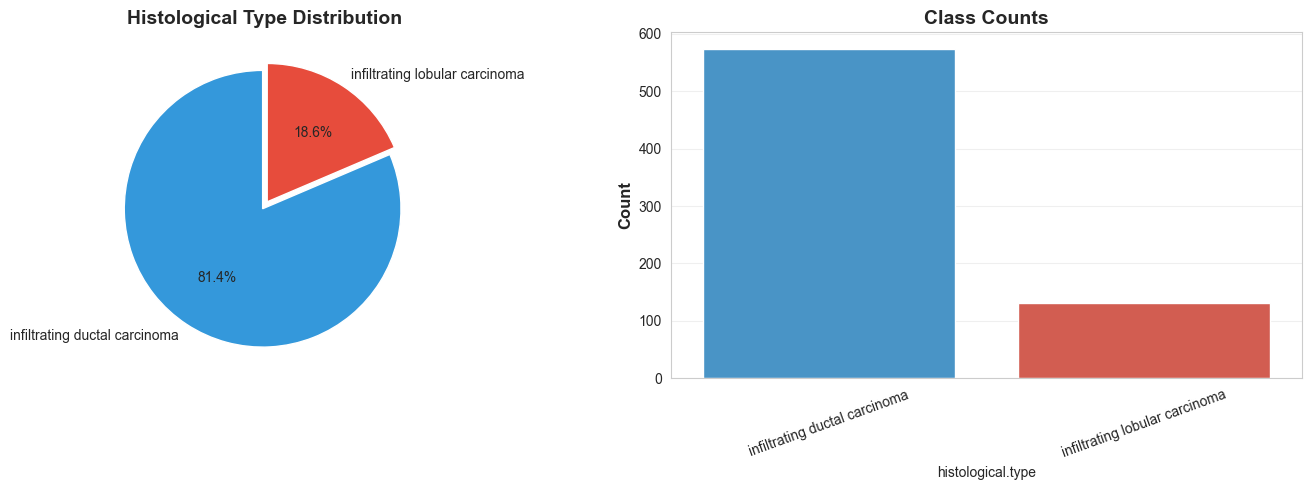

In [5]:
# Target distribution
value_counts = df[TARGET_COLUMN].value_counts()
print('\n' + '='*80)
print('TARGET DISTRIBUTION')
print('='*80)
print(value_counts)
print('\nClass proportions:')
print((value_counts / len(df)).round(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, explode=[0.03]*len(value_counts), colors=['#3498db', '#e74c3c'])
axes[0].set_title('Histological Type Distribution', fontsize=14, weight='bold')

sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Count', fontsize=12, weight='bold')
axes[1].set_title('Class Counts', fontsize=14, weight='bold')
axes[1].tick_params(axis='x', rotation=20)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Missing value analysis
missing_total = df.isnull().sum().sum()
missing_percent = missing_total / (df.shape[0] * df.shape[1]) * 100

print('\n' + '='*80)
print('MISSING VALUE ANALYSIS')
print('='*80)
print(f'Total missing values: {missing_total:,}')
print(f'Percent missing: {missing_percent:.2f}%')

if missing_total > 0:
    cols_with_missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
    print(f'Columns with missing values: {len(cols_with_missing)}')
    display(cols_with_missing.head(10))


MISSING VALUE ANALYSIS
Total missing values: 389
Percent missing: 0.03%
Columns with missing values: 3


HER2.Final.Status    145
PR.Status            122
ER.Status            122
dtype: int64

## 2. Data Preprocessing

In [7]:
# Feature matrix and target vector
# Define columns to exclude (target + clinical status columns that could cause data leakage)
exclude_cols = [
    TARGET_COLUMN,
    'PR.Status',           # Progesterone receptor status (clinical label)
    'ER.Status',           # Estrogen receptor status (clinical label)
    'HER2.Final.Status',   # HER2 status (clinical label)
    'vital.status'         # Patient outcome (not relevant for histological prediction)
]

# Remove excluded columns that actually exist in the dataset
exclude_cols = [col for col in exclude_cols if col in df.columns]
feature_cols = [col for col in df.columns if col not in exclude_cols]

print('='*80)
print('EXCLUDED COLUMNS (Prevent Data Leakage)')
print('='*80)
print(f'Excluding {len(exclude_cols)} columns:')
for col in exclude_cols:
    if col != TARGET_COLUMN:
        print(f'  - {col}: Clinical label/outcome variable')
print(f'  - {TARGET_COLUMN}: Target variable')

X = df[feature_cols]
y = df[TARGET_COLUMN]

# Check data types and identify non-numeric columns
print('\n' + '='*80)
print('DATA TYPE ANALYSIS')
print('='*80)
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f'Found {len(non_numeric_cols)} non-numeric columns:')
    for col in non_numeric_cols[:10]:  # Show first 10
        print(f'  - {col}: {X[col].unique()[:5].tolist()}')
    print(f'\nRemoving {len(non_numeric_cols)} non-numeric columns...')
    X = X.select_dtypes(include=[np.number])
    print(f'Remaining numeric features: {X.shape[1]}')
else:
    print('All features are numeric.')

print('\n' + '='*80)
print('FEATURE / TARGET SHAPES')
print('='*80)
print(f'Feature matrix: {X.shape}')
print(f'Target vector: {y.shape}')

EXCLUDED COLUMNS (Prevent Data Leakage)
Excluding 5 columns:
  - PR.Status: Clinical label/outcome variable
  - ER.Status: Clinical label/outcome variable
  - HER2.Final.Status: Clinical label/outcome variable
  - vital.status: Clinical label/outcome variable
  - histological.type: Target variable

DATA TYPE ANALYSIS
All features are numeric.

FEATURE / TARGET SHAPES
Feature matrix: (705, 1936)
Target vector: (705,)


In [8]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=3
)

print('='*80)
print('TRAIN / TEST SPLIT')
print('='*80)
print(f'Train samples: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test samples:  {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)')
print('\nTrain distribution:')
print(y_train.value_counts())
print('\nTest distribution:')
print(y_test.value_counts())

TRAIN / TEST SPLIT
Train samples: 564 (80.0%)
Test samples:  141 (20.0%)

Train distribution:
histological.type
infiltrating ductal carcinoma     459
infiltrating lobular carcinoma    105
Name: count, dtype: int64

Test distribution:
histological.type
infiltrating ductal carcinoma     115
infiltrating lobular carcinoma     26
Name: count, dtype: int64


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('='*80)
print('SCALING SUMMARY')
print('='*80)
print(f'Scaled train shape: {X_train_scaled.shape}')
print(f'Scaled test shape:  {X_test_scaled.shape}')
print(f'Mean (approx): {X_train_scaled.mean():.4f}')
print(f'Std (approx):  {X_train_scaled.std():.4f}')

SCALING SUMMARY
Scaled train shape: (564, 1936)
Scaled test shape:  (141, 1936)
Mean (approx): -0.0000
Std (approx):  1.0000


## 3. PCA Transformation

In [10]:
# Variance threshold to drop near-constant features
var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_scaled)
X_test_var = var_selector.transform(X_test_scaled)
selected_feature_indices = var_selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]

removed = X_train_scaled.shape[1] - X_train_var.shape[1]
print('='*80)
print('VARIANCE THRESHOLD RESULTS')
print('='*80)
print(f'Original features: {X_train_scaled.shape[1]:,}')
print(f'Remaining features: {X_train_var.shape[1]:,}')
print(f'Removed low-variance features: {removed:,}')

VARIANCE THRESHOLD RESULTS
Original features: 1,936
Remaining features: 1,936
Removed low-variance features: 0


PCA ANALYSIS
Total components: 564
Components for 95% variance: 325
Variance explained by PC1: 0.0850
Variance explained by PC2: 0.0615
Cumulative variance (PC1+PC2): 0.1465

USING PCA COMPONENTS FOR LOGISTIC REGRESSION
PCA components (95% variance): 325
These 325 components will be used directly in the model
Benefits: Decorrelated features, optimal for linear models


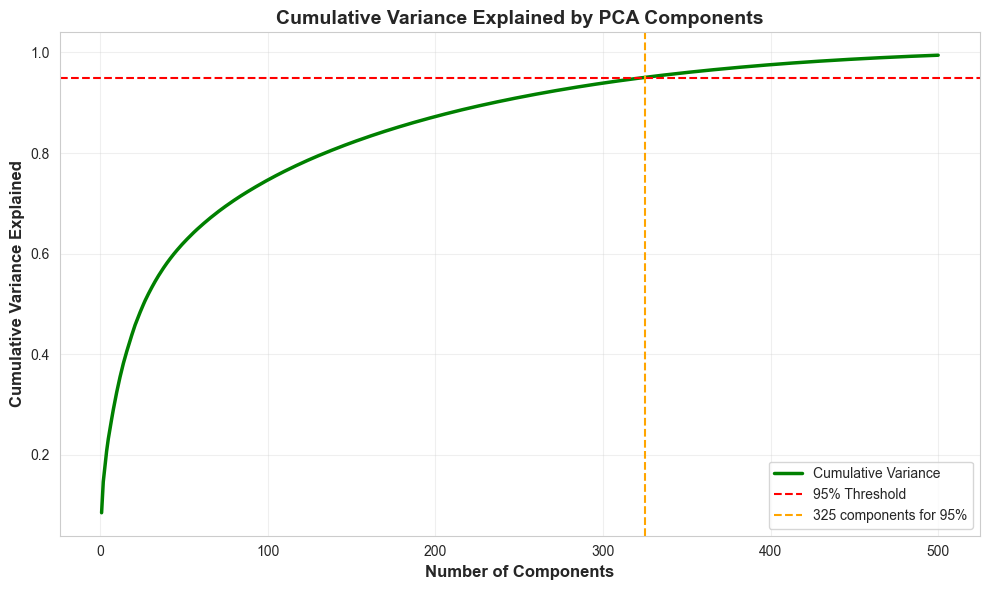

In [11]:
# PCA Analysis - Transform data to PCA components
from sklearn.decomposition import PCA

# Fit PCA on all variance-filtered features
pca = PCA(random_state=3)
X_train_pca = pca.fit_transform(X_train_var)
X_test_pca = pca.transform(X_test_var)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print('='*80)
print('PCA ANALYSIS')
print('='*80)
print(f'Total components: {len(pca.explained_variance_ratio_)}')
print(f'Components for 95% variance: {n_components_95}')
print(f'Variance explained by PC1: {pca.explained_variance_ratio_[0]:.4f}')
print(f'Variance explained by PC2: {pca.explained_variance_ratio_[1]:.4f}')
print(f'Cumulative variance (PC1+PC2): {cumulative_variance[1]:.4f}')

print('\n' + '='*80)
print(f'USING PCA COMPONENTS FOR LOGISTIC REGRESSION')
print('='*80)
print(f'PCA components (95% variance): {n_components_95}')
print(f'These {n_components_95} components will be used directly in the model')
print('Benefits: Decorrelated features, optimal for linear models')
print('='*80)

# Cumulative variance plot
n_components_to_show = min(500, len(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_to_show + 1), 
         cumulative_variance[:n_components_to_show], 
         'g-', linewidth=2.5, label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=1.5, label='95% Threshold')
plt.axvline(x=n_components_95, color='orange', linestyle='--', linewidth=1.5, 
            label=f'{n_components_95} components for 95%')
plt.xlabel('Number of Components', fontsize=12, weight='bold')
plt.ylabel('Cumulative Variance Explained', fontsize=12, weight='bold')
plt.title('Cumulative Variance Explained by PCA Components', fontsize=14, weight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Hyperparameter Tuning

In [12]:
# Reduce PCA to 95% variance components
X_train_pca_reduced = X_train_pca[:, :n_components_95]
X_test_pca_reduced = X_test_pca[:, :n_components_95]

print('='*80)
print('PCA DIMENSIONALITY REDUCTION')
print('='*80)
print(f'Original PCA components: {X_train_pca.shape[1]}')
print(f'Reduced to (95% variance): {n_components_95}')
print(f'Train shape: {X_train_pca_reduced.shape}')
print(f'Test shape: {X_test_pca_reduced.shape}')

# Pipeline: SMOTE + Logistic Regression on PCA components
# Using imbalanced-learn pipeline to include SMOTE
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=3)),
    ('classifier', LogisticRegression(random_state=3, max_iter=2000))
])

# Hyperparameter grid for Logistic Regression (Balanced for 4-5 min runtime)
param_grid = {
    'smote__k_neighbors': [3, 5, 7],  # SMOTE neighbors parameter
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # How much to oversample minority class
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (full range)
    'classifier__penalty': ['l2'],  # L2 regularization (fastest, still effective)
    'classifier__solver': ['lbfgs'],  # Fast solver for L2
    'classifier__class_weight': [
        None,
        'balanced',  # Auto weight: n_samples / (n_classes * np.bincount(y))
        {"infiltrating ductal carcinoma": 1, "infiltrating lobular carcinoma": 4.38}  # Exact ratio
    ]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=1,  # Reduced verbosity
    n_jobs=-1,
    return_train_score=True
)

print('\n' + '='*80)
print('LOGISTIC REGRESSION WITH PCA COMPONENTS')
print('='*80)
print(f'Using {n_components_95} PCA components (95% variance)')
print('SMOTE oversampling + class weights for imbalance handling')
print('Tuning: SMOTE parameters, C (regularization), and class weights')
print(f'Total parameter combinations: 3 SMOTE_k × 3 sampling × 6 C × 3 weights = 162 combinations')
print(f'With 5-fold CV: 162 × 5 = 810 model fits (~4-5 minutes)')
print('='*80)

start_time = time.time()
grid_search.fit(X_train_pca_reduced, y_train)
tuning_time = time.time() - start_time

print('\n' + '='*80)
print('BEST HYPERPARAMETERS')
print('='*80)
print(f'Best CV ROC-AUC: {grid_search.best_score_:.4f}')
print(f'Total tuning time: {tuning_time/60:.2f} minutes')
for param, value in grid_search.best_params_.items():
    print(f'  {param}: {value}')

tuned_model = grid_search.best_estimator_

PCA DIMENSIONALITY REDUCTION
Original PCA components: 564
Reduced to (95% variance): 325
Train shape: (564, 325)
Test shape: (141, 325)

LOGISTIC REGRESSION WITH PCA COMPONENTS
Using 325 PCA components (95% variance)
SMOTE oversampling + class weights for imbalance handling
Tuning: SMOTE parameters, C (regularization), and class weights
Total parameter combinations: 3 SMOTE_k × 3 sampling × 6 C × 3 weights = 162 combinations
With 5-fold CV: 162 × 5 = 810 model fits (~4-5 minutes)
Fitting 5 folds for each of 162 candidates, totalling 810 fits

BEST HYPERPARAMETERS
Best CV ROC-AUC: 0.9201
Total tuning time: 0.79 minutes
  classifier__C: 0.01
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: lbfgs
  smote__k_neighbors: 5
  smote__sampling_strategy: 0.5

BEST HYPERPARAMETERS
Best CV ROC-AUC: 0.9201
Total tuning time: 0.79 minutes
  classifier__C: 0.01
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: lbfgs
  smote__k_neighbors: 

### 4.1 Visualize SMOTE Balancing Effect

Now that we've completed hyperparameter tuning, let's visualize how SMOTE (using the best parameters) balances the dataset.

SMOTE DEMONSTRATION - BALANCING THE DATASET
Using best hyperparameters from GridSearch:
  k_neighbors: 5
  sampling_strategy: 0.5

ORIGINAL CLASS DISTRIBUTION (Before SMOTE):
histological.type
infiltrating ductal carcinoma     459
infiltrating lobular carcinoma    105
Name: count, dtype: int64

Class ratio: 4.37:1

AFTER SMOTE (sampling_strategy=0.5):
histological.type
infiltrating ductal carcinoma     459
infiltrating lobular carcinoma    229
Name: count, dtype: int64

Class ratio: 2.00:1

Original training samples: 564
After SMOTE samples: 688
New synthetic samples created: 124


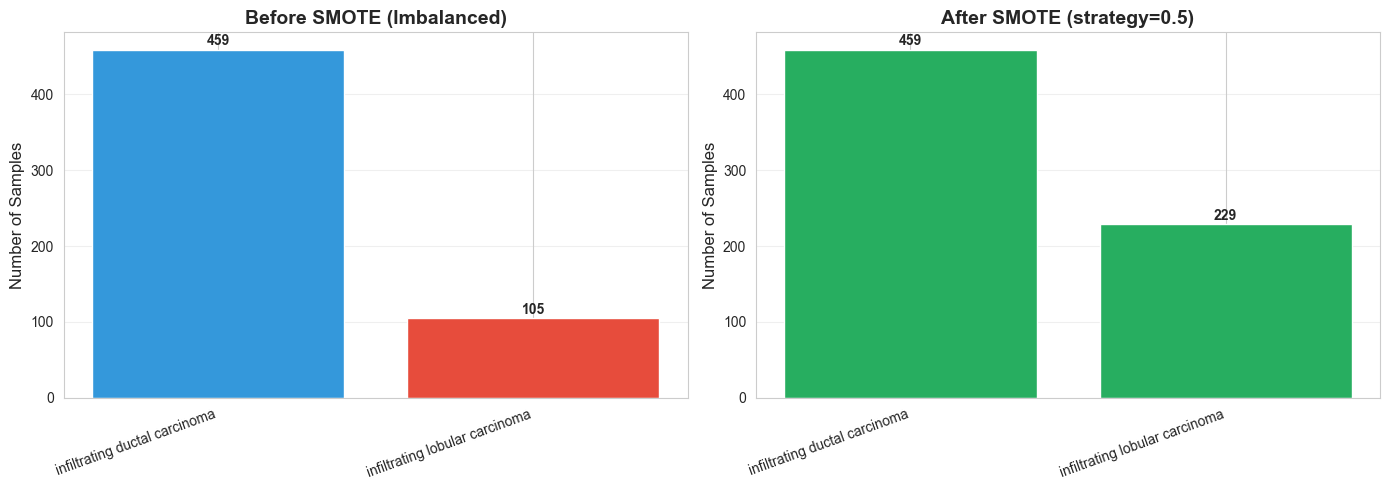


✅ SMOTE was applied automatically during cross-validation
   Best parameters: k_neighbors=5, sampling_strategy=0.5


In [13]:
# Demonstrate SMOTE balancing with best parameters found
best_k = grid_search.best_params_.get('smote__k_neighbors', 5)
best_strategy = grid_search.best_params_.get('smote__sampling_strategy', 1.0)

print('='*80)
print('SMOTE DEMONSTRATION - BALANCING THE DATASET')
print('='*80)
print(f'Using best hyperparameters from GridSearch:')
print(f'  k_neighbors: {best_k}')
print(f'  sampling_strategy: {best_strategy}')

# Original class distribution
print('\nORIGINAL CLASS DISTRIBUTION (Before SMOTE):')
print(y_train.value_counts())
print(f'\nClass ratio: {y_train.value_counts().iloc[0] / y_train.value_counts().iloc[1]:.2f}:1')

# Apply SMOTE with best parameters
smote_best = SMOTE(random_state=3, k_neighbors=best_k, sampling_strategy=best_strategy)
X_train_pca_reduced = X_train_pca[:, :n_components_95]
X_resampled, y_resampled = smote_best.fit_resample(X_train_pca_reduced, y_train)

print(f'\nAFTER SMOTE (sampling_strategy={best_strategy}):')
print(pd.Series(y_resampled).value_counts())
print(f'\nClass ratio: {pd.Series(y_resampled).value_counts().iloc[0] / pd.Series(y_resampled).value_counts().iloc[1]:.2f}:1')
print(f'\nOriginal training samples: {len(y_train)}')
print(f'After SMOTE samples: {len(y_resampled)}')
print(f'New synthetic samples created: {len(y_resampled) - len(y_train)}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
axes[0].bar(y_train.value_counts().index, y_train.value_counts().values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Before SMOTE (Imbalanced)', fontsize=14, weight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_xticklabels(y_train.value_counts().index, rotation=20, ha='right')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(y_train.value_counts().values):
    axes[0].text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(pd.Series(y_resampled).value_counts().index, pd.Series(y_resampled).value_counts().values, 
            color=['#27ae60', '#27ae60'])
axes[1].set_title(f'After SMOTE (strategy={best_strategy})', fontsize=14, weight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_xticklabels(pd.Series(y_resampled).value_counts().index, rotation=20, ha='right')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(pd.Series(y_resampled).value_counts().values):
    axes[1].text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print('\n✅ SMOTE was applied automatically during cross-validation')
print(f'   Best parameters: k_neighbors={best_k}, sampling_strategy={best_strategy}')

## 5. Evaluation

In [14]:
# Predictions for both train and test sets
y_train_pred = tuned_model.predict(X_train_pca_reduced)
y_train_pred_proba = tuned_model.predict_proba(X_train_pca_reduced)[:, 1]

y_test_pred = tuned_model.predict(X_test_pca_reduced)
y_test_pred_proba = tuned_model.predict_proba(X_test_pca_reduced)[:, 1]

# Calculate metrics for TRAIN set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')
train_roc_auc = roc_auc_score((y_train == 'infiltrating lobular carcinoma').astype(int), y_train_pred_proba)

# Calculate metrics for TEST set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_roc_auc = roc_auc_score((y_test == 'infiltrating lobular carcinoma').astype(int), y_test_pred_proba)

print('='*80)
print('MODEL PERFORMANCE SUMMARY')
print('='*80)
print(f'{"Metric":<20} {"Train":<15} {"Test":<15} {"Difference":<15}')
print('-'*80)
print(f'{"Accuracy":<20} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy - test_accuracy):<15.4f}')
print(f'{"Precision (macro)":<20} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision - test_precision):<15.4f}')
print(f'{"Recall (macro)":<20} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall - test_recall):<15.4f}')
print(f'{"F1-score (macro)":<20} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1 - test_f1):<15.4f}')
print(f'{"ROC-AUC":<20} {train_roc_auc:<15.4f} {test_roc_auc:<15.4f} {abs(train_roc_auc - test_roc_auc):<15.4f}')
print('='*80)

if abs(train_accuracy - test_accuracy) < 0.05:
    print('✅ Good generalization: Train and test performance are similar')
else:
    print('⚠️ Potential overfitting: Large gap between train and test performance')

print('\n' + '='*80)
print('TEST SET - CLASSIFICATION REPORT')
print('='*80)
print(classification_report(y_test, y_test_pred))

MODEL PERFORMANCE SUMMARY
Metric               Train           Test            Difference     
--------------------------------------------------------------------------------
Accuracy             0.9894          0.9220          0.0674         
Precision (macro)    0.9824          0.8670          0.1155         
Recall (macro)       0.9824          0.8778          0.1047         
F1-score (macro)     0.9824          0.8722          0.1102         
ROC-AUC              0.9995          0.9559          0.0436         
⚠️ Potential overfitting: Large gap between train and test performance

TEST SET - CLASSIFICATION REPORT
                                precision    recall  f1-score   support

 infiltrating ductal carcinoma       0.96      0.95      0.95       115
infiltrating lobular carcinoma       0.78      0.81      0.79        26

                      accuracy                           0.92       141
                     macro avg       0.87      0.88      0.87       141
            

### 5.1 Comprehensive Visualization: Train vs Test Performance

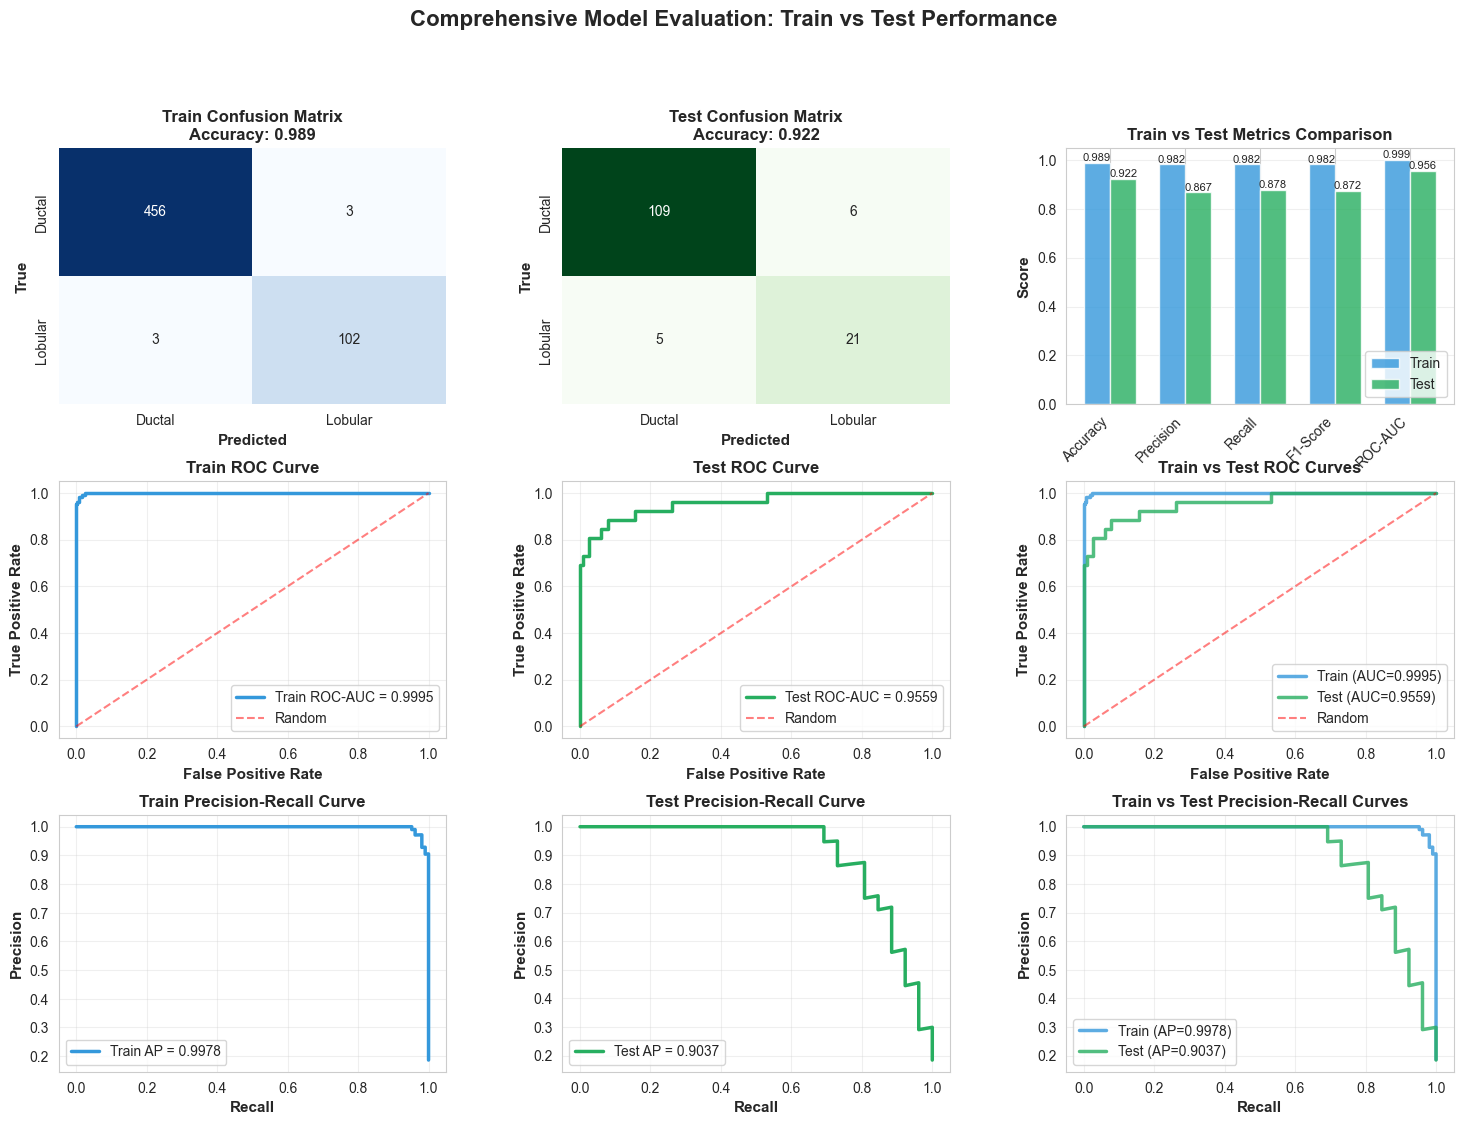

✅ Comprehensive visualization complete!
   - Row 1: Confusion matrices and metrics comparison
   - Row 2: ROC curves for train, test, and combined
   - Row 3: Precision-Recall curves for train, test, and combined


In [15]:
# Create comprehensive visualization with all results
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Confusion Matrices (Train and Test)
ax1 = fig.add_subplot(gs[0, 0])
cm_train = confusion_matrix(y_train, y_train_pred, labels=value_counts.index)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Ductal', 'Lobular'], yticklabels=['Ductal', 'Lobular'], ax=ax1)
ax1.set_xlabel('Predicted', fontsize=11, weight='bold')
ax1.set_ylabel('True', fontsize=11, weight='bold')
ax1.set_title(f'Train Confusion Matrix\nAccuracy: {train_accuracy:.3f}', fontsize=12, weight='bold')

ax2 = fig.add_subplot(gs[0, 1])
cm_test = confusion_matrix(y_test, y_test_pred, labels=value_counts.index)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Ductal', 'Lobular'], yticklabels=['Ductal', 'Lobular'], ax=ax2)
ax2.set_xlabel('Predicted', fontsize=11, weight='bold')
ax2.set_ylabel('True', fontsize=11, weight='bold')
ax2.set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.3f}', fontsize=12, weight='bold')

# Row 1, Col 3: Metrics Comparison Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1, train_roc_auc]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]

x = np.arange(len(metrics_names))
width = 0.35
bars1 = ax3.bar(x - width/2, train_metrics, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax3.bar(x + width/2, test_metrics, width, label='Test', color='#27ae60', alpha=0.8)

ax3.set_ylabel('Score', fontsize=11, weight='bold')
ax3.set_title('Train vs Test Metrics Comparison', fontsize=12, weight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=45, ha='right')
ax3.legend(loc='lower right')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Row 2: ROC Curves (Train and Test)
ax4 = fig.add_subplot(gs[1, 0])
binary_y_train = (y_train == 'infiltrating lobular carcinoma').astype(int)
fpr_train, tpr_train, _ = roc_curve(binary_y_train, y_train_pred_proba)
ax4.plot(fpr_train, tpr_train, color='#3498db', lw=2.5, label=f'Train ROC-AUC = {train_roc_auc:.4f}')
ax4.plot([0, 1], [0, 1], 'r--', lw=1.5, label='Random', alpha=0.5)
ax4.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax4.set_title('Train ROC Curve', fontsize=12, weight='bold')
ax4.legend(loc='lower right')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
binary_y_test = (y_test == 'infiltrating lobular carcinoma').astype(int)
fpr_test, tpr_test, _ = roc_curve(binary_y_test, y_test_pred_proba)
ax5.plot(fpr_test, tpr_test, color='#27ae60', lw=2.5, label=f'Test ROC-AUC = {test_roc_auc:.4f}')
ax5.plot([0, 1], [0, 1], 'r--', lw=1.5, label='Random', alpha=0.5)
ax5.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax5.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax5.set_title('Test ROC Curve', fontsize=12, weight='bold')
ax5.legend(loc='lower right')
ax5.grid(alpha=0.3)

# Row 2, Col 3: Combined ROC Curves
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(fpr_train, tpr_train, color='#3498db', lw=2.5, label=f'Train (AUC={train_roc_auc:.4f})', alpha=0.8)
ax6.plot(fpr_test, tpr_test, color='#27ae60', lw=2.5, label=f'Test (AUC={test_roc_auc:.4f})', alpha=0.8)
ax6.plot([0, 1], [0, 1], 'r--', lw=1.5, label='Random', alpha=0.5)
ax6.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax6.set_title('Train vs Test ROC Curves', fontsize=12, weight='bold')
ax6.legend(loc='lower right')
ax6.grid(alpha=0.3)

# Row 3: Precision-Recall Curves
ax7 = fig.add_subplot(gs[2, 0])
precision_train, recall_train, _ = precision_recall_curve(binary_y_train, y_train_pred_proba)
avg_precision_train = average_precision_score(binary_y_train, y_train_pred_proba)
ax7.plot(recall_train, precision_train, color='#3498db', lw=2.5, label=f'Train AP = {avg_precision_train:.4f}')
ax7.set_xlabel('Recall', fontsize=11, weight='bold')
ax7.set_ylabel('Precision', fontsize=11, weight='bold')
ax7.set_title('Train Precision-Recall Curve', fontsize=12, weight='bold')
ax7.legend(loc='best')
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
precision_test, recall_test, _ = precision_recall_curve(binary_y_test, y_test_pred_proba)
avg_precision_test = average_precision_score(binary_y_test, y_test_pred_proba)
ax8.plot(recall_test, precision_test, color='#27ae60', lw=2.5, label=f'Test AP = {avg_precision_test:.4f}')
ax8.set_xlabel('Recall', fontsize=11, weight='bold')
ax8.set_ylabel('Precision', fontsize=11, weight='bold')
ax8.set_title('Test Precision-Recall Curve', fontsize=12, weight='bold')
ax8.legend(loc='best')
ax8.grid(alpha=0.3)

# Row 3, Col 3: Combined Precision-Recall Curves
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(recall_train, precision_train, color='#3498db', lw=2.5, label=f'Train (AP={avg_precision_train:.4f})', alpha=0.8)
ax9.plot(recall_test, precision_test, color='#27ae60', lw=2.5, label=f'Test (AP={avg_precision_test:.4f})', alpha=0.8)
ax9.set_xlabel('Recall', fontsize=11, weight='bold')
ax9.set_ylabel('Precision', fontsize=11, weight='bold')
ax9.set_title('Train vs Test Precision-Recall Curves', fontsize=12, weight='bold')
ax9.legend(loc='best')
ax9.grid(alpha=0.3)

plt.suptitle('Comprehensive Model Evaluation: Train vs Test Performance', 
             fontsize=16, weight='bold', y=0.995)
plt.show()

print('✅ Comprehensive visualization complete!')
print('   - Row 1: Confusion matrices and metrics comparison')
print('   - Row 2: ROC curves for train, test, and combined')
print('   - Row 3: Precision-Recall curves for train, test, and combined')

TOP 20 PCA COMPONENTS BY COEFFICIENT MAGNITUDE
Positive coefficients → favor lobular carcinoma
Negative coefficients → favor ductal carcinoma


,component,coefficient,abs_coefficient
0,PC49,-0.184965,0.184965
1,PC2,0.162446,0.162446
2,PC70,0.156248,0.156248
3,PC32,0.155681,0.155681
4,PC89,0.152357,0.152357
5,PC46,-0.148200,0.148200
6,PC41,-0.142506,0.142506
7,PC243,0.117823,0.117823
8,PC130,0.116282,0.116282
9,PC31,0.113930,0.113930


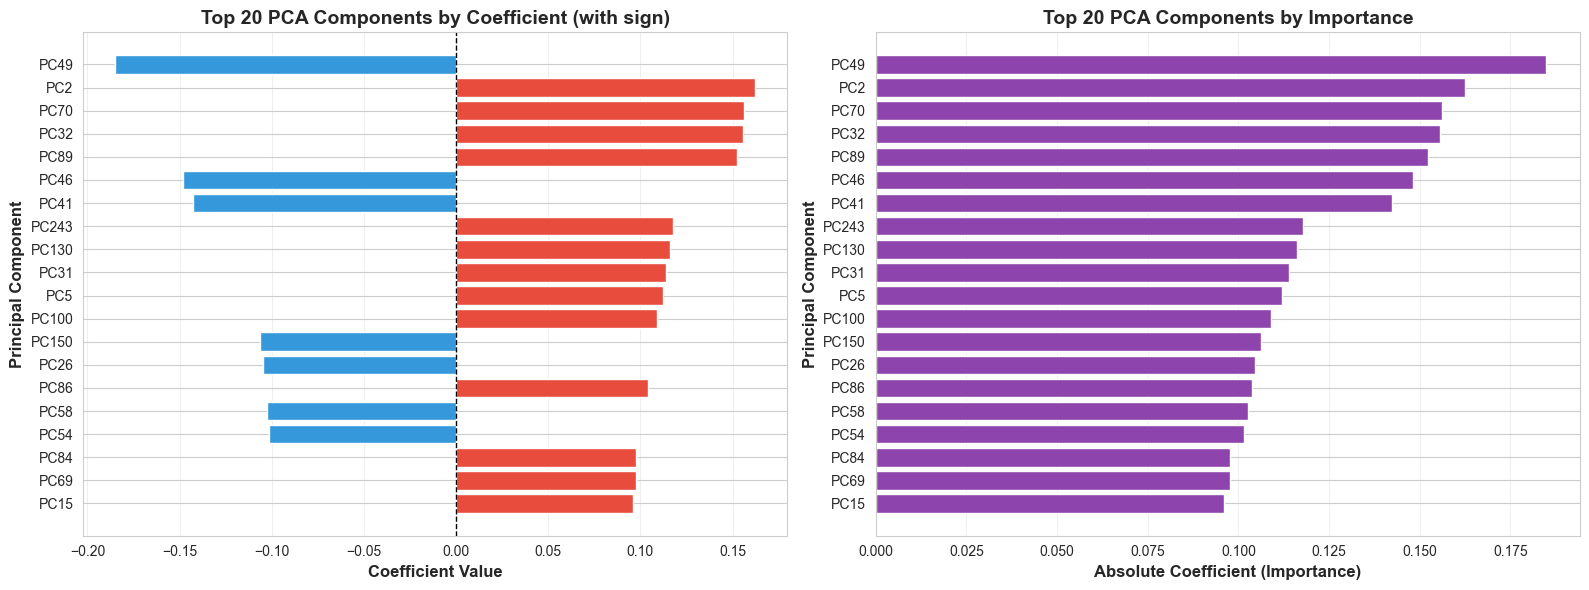

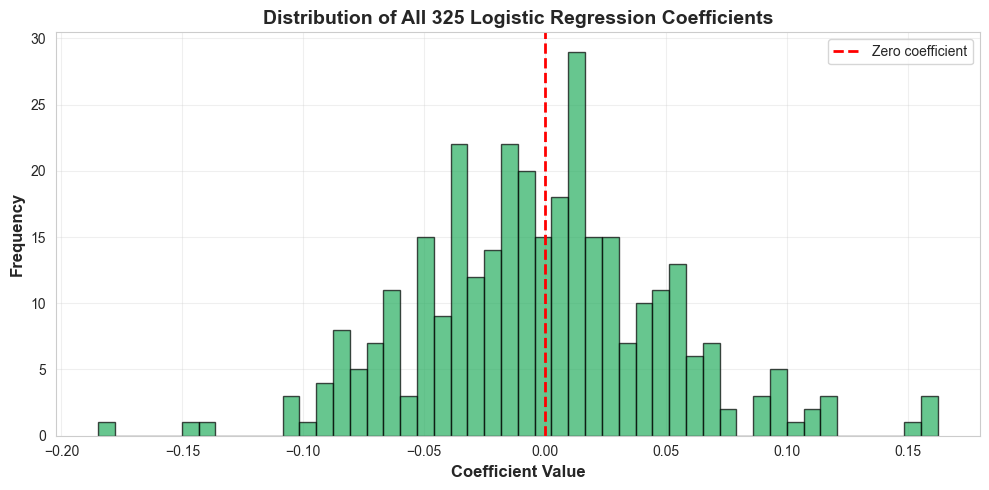

In [16]:
# Top PCA components by coefficient magnitude
coefficients = tuned_model.named_steps['classifier'].coef_[0]

# Get absolute values for importance ranking
abs_coefficients = np.abs(coefficients)
top_indices = np.argsort(abs_coefficients)[::-1][:20]

top_components = [f'PC{i+1}' for i in top_indices]
top_coefs = coefficients[top_indices]
top_abs_coefs = abs_coefficients[top_indices]

importance_df = pd.DataFrame({
    'component': top_components,
    'coefficient': top_coefs,
    'abs_coefficient': top_abs_coefs
}).sort_values('abs_coefficient', ascending=False)

top_n = 20
print('='*80)
print(f'TOP {top_n} PCA COMPONENTS BY COEFFICIENT MAGNITUDE')
print('='*80)
print('Positive coefficients → favor lobular carcinoma')
print('Negative coefficients → favor ductal carcinoma')
print('='*80)
display(importance_df.head(top_n))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top coefficients (with sign)
colors = ['#e74c3c' if c > 0 else '#3498db' for c in top_coefs]
axes[0].barh(range(len(top_coefs)), top_coefs, color=colors)
axes[0].set_yticks(range(len(top_components)))
axes[0].set_yticklabels(top_components)
axes[0].set_xlabel('Coefficient Value', fontsize=12, weight='bold')
axes[0].set_ylabel('Principal Component', fontsize=12, weight='bold')
axes[0].set_title('Top 20 PCA Components by Coefficient (with sign)', fontsize=14, weight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Bar plot of absolute coefficients (importance)
axes[1].barh(range(len(top_abs_coefs)), top_abs_coefs, color='#8e44ad')
axes[1].set_yticks(range(len(top_components)))
axes[1].set_yticklabels(top_components)
axes[1].set_xlabel('Absolute Coefficient (Importance)', fontsize=12, weight='bold')
axes[1].set_ylabel('Principal Component', fontsize=12, weight='bold')
axes[1].set_title('Top 20 PCA Components by Importance', fontsize=14, weight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Additional: Distribution of all coefficients
plt.figure(figsize=(10, 5))
plt.hist(coefficients, bins=50, color='#27ae60', edgecolor='black', alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12, weight='bold')
plt.ylabel('Frequency', fontsize=12, weight='bold')
plt.title(f'Distribution of All {len(coefficients)} Logistic Regression Coefficients', fontsize=14, weight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero coefficient')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Final Summary

In [17]:
print('\n' + '='*80)
print('FINAL SUMMARY')
print('='*80)

best_params = grid_search.best_params_

print('Dataset:')
print(f'  Samples: {len(df):,}')
print(f'  Features (original): {len(feature_cols):,}')
print(f'  PCA components used: {n_components_95} (95% variance)')

print('\nModeling:')
print('  Algorithm: Logistic Regression on PCA components')
print('  Feature transformation: PCA (decorrelated components)')
print(f'  Regularization: {best_params.get("classifier__penalty", "N/A")}')
print(f'  C parameter: {best_params.get("classifier__C", "N/A")}')
print('  Hyperparameter search: GridSearchCV (stratified 5-fold CV)')
print(f'  Best CV ROC-AUC: {grid_search.best_score_:.4f}')

print('\nTest performance:')
print(f'  Accuracy: {test_accuracy:.4f}')
print(f'  Precision (macro): {test_precision:.4f}')
print(f'  Recall (macro): {test_recall:.4f}')
print(f'  F1-score (macro): {test_f1:.4f}')
print(f'  ROC-AUC: {test_roc_auc:.4f}')

print('\nTrain vs Test:')
print(f'  Overfitting gap (accuracy): {abs(train_accuracy - test_accuracy):.4f}')
print(f'  Overfitting gap (ROC-AUC): {abs(train_roc_auc - test_roc_auc):.4f}')

print('\nKey advantages of this approach:')
print('  ✅ PCA components are decorrelated → optimal for linear models')
print('  ✅ Faster training than Random Forest')
print('  ✅ Native probability estimates for ROC curve')
print('  ✅ Interpretable coefficients show component importance')

print('\nInterpretation:')
if test_roc_auc >= 0.85:
    print('  ✅ Excellent separation between histological types.')
elif test_roc_auc >= 0.75:
    print('  ✅ Good discrimination with room for further improvement.')
elif test_roc_auc >= 0.65:
    print('  ⚠️ Acceptable performance; consider additional feature engineering.')
else:
    print('  ⚠️ Model performance is limited; investigate alternative models and preprocessing.')

print('\n' + '='*80)
print('Analysis complete!')
print('='*80)


FINAL SUMMARY
Dataset:
  Samples: 705
  Features (original): 1,936
  PCA components used: 325 (95% variance)

Modeling:
  Algorithm: Logistic Regression on PCA components
  Feature transformation: PCA (decorrelated components)
  Regularization: l2
  C parameter: 0.01
  Hyperparameter search: GridSearchCV (stratified 5-fold CV)
  Best CV ROC-AUC: 0.9201

Test performance:
  Accuracy: 0.9220
  Precision (macro): 0.8670
  Recall (macro): 0.8778
  F1-score (macro): 0.8722
  ROC-AUC: 0.9559

Train vs Test:
  Overfitting gap (accuracy): 0.0674
  Overfitting gap (ROC-AUC): 0.0436

Key advantages of this approach:
  ✅ PCA components are decorrelated → optimal for linear models
  ✅ Faster training than Random Forest
  ✅ Native probability estimates for ROC curve
  ✅ Interpretable coefficients show component importance

Interpretation:
  ✅ Excellent separation between histological types.

Analysis complete!


## Comprehensive Model Evaluation: Train vs Test Performance

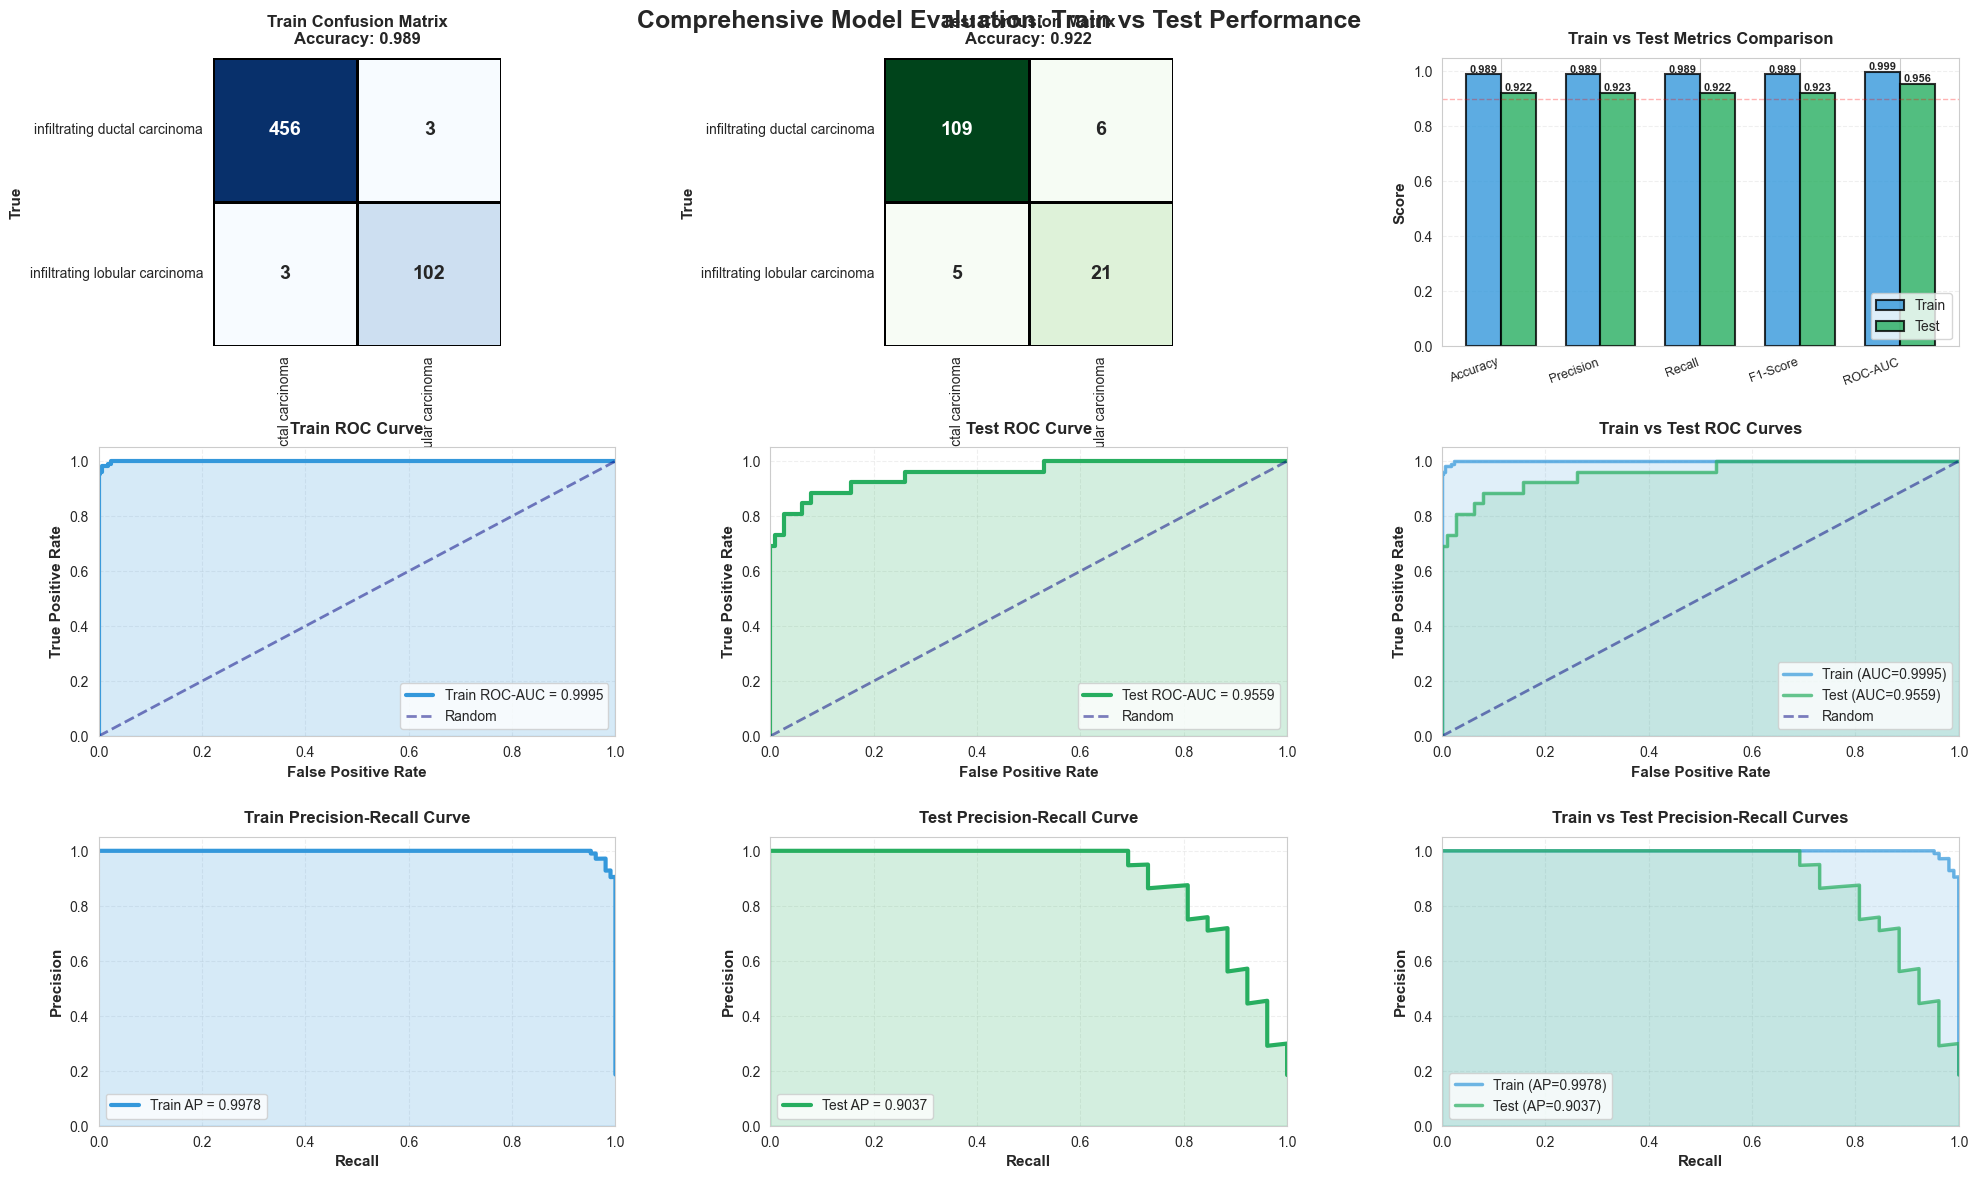


COMPREHENSIVE PERFORMANCE SUMMARY

Metric                    Train           Test            Difference     
----------------------------------------------------------------------
Accuracy                  0.9894          0.9220          0.0674         
Precision                 0.9894          0.9233          0.0661         
Recall                    0.9894          0.9220          0.0674         
F1-Score                  0.9894          0.9226          0.0668         
ROC-AUC                   0.9995          0.9559          0.0436         
Average Precision         0.9978          0.9037          0.0941         


In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder

# Encode string labels to numeric for ROC/PR curves
le_temp = LabelEncoder()
y_train_encoded = le_temp.fit_transform(y_train)
y_test_encoded = le_temp.transform(y_test)

# Calculate predictions and probabilities using the tuned model
y_train_pred = tuned_model.predict(X_train_pca_reduced)
y_test_pred = tuned_model.predict(X_test_pca_reduced)
y_train_prob = tuned_model.predict_proba(X_train_pca_reduced)[:, 1]
y_test_prob = tuned_model.predict_proba(X_test_pca_reduced)[:, 1]

# Encode predictions as well
y_train_pred_encoded = le_temp.transform(y_train_pred)
y_test_pred_encoded = le_temp.transform(y_test_pred)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

train_accuracy = accuracy_score(y_train_encoded, y_train_pred_encoded)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_encoded)
train_precision = precision_score(y_train_encoded, y_train_pred_encoded, average='weighted')
test_precision = precision_score(y_test_encoded, y_test_pred_encoded, average='weighted')
train_recall = recall_score(y_train_encoded, y_train_pred_encoded, average='weighted')
test_recall = recall_score(y_test_encoded, y_test_pred_encoded, average='weighted')
train_f1 = f1_score(y_train_encoded, y_train_pred_encoded, average='weighted')
test_f1 = f1_score(y_test_encoded, y_test_pred_encoded, average='weighted')

# ROC curve calculations (now with encoded labels)
fpr_train, tpr_train, _ = roc_curve(y_train_encoded, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_prob)
train_auc = auc(fpr_train, tpr_train)
test_auc = auc(fpr_test, tpr_test)

# Precision-Recall curve calculations
precision_train, recall_train, _ = precision_recall_curve(y_train_encoded, y_train_prob)
precision_test, recall_test, _ = precision_recall_curve(y_test_encoded, y_test_prob)
train_ap = average_precision_score(y_train_encoded, y_train_prob)
test_ap = average_precision_score(y_test_encoded, y_test_prob)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred_encoded)
cm_test = confusion_matrix(y_test_encoded, y_test_pred_encoded)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Comprehensive Model Evaluation: Train vs Test Performance', 
             fontsize=18, weight='bold', y=0.98)

# Define grid
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, top=0.94, bottom=0.05, left=0.05, right=0.98)

# 1. Train Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=le_temp.classes_, yticklabels=le_temp.classes_, 
            ax=ax1, square=True, linewidths=2, linecolor='black', annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontsize=11, weight='bold')
ax1.set_ylabel('True', fontsize=11, weight='bold')
ax1.set_title(f'Train Confusion Matrix\nAccuracy: {train_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)

# 2. Test Confusion Matrix
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=le_temp.classes_, yticklabels=le_temp.classes_,
            ax=ax2, square=True, linewidths=2, linecolor='black', annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted', fontsize=11, weight='bold')
ax2.set_ylabel('True', fontsize=11, weight='bold')
ax2.set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)

# 3. Metrics Comparison Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_scores = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_auc]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x - width/2, train_scores, width, label='Train', 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x + width/2, test_scores, width, label='Test', 
                color='#27ae60', alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontsize=11, weight='bold')
ax3.set_title('Train vs Test Metrics Comparison', fontsize=12, weight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=20, ha='right', fontsize=9)
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim([0, 1.05])
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=0.9, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')

# 4. Train ROC Curve
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(fpr_train, tpr_train, color='#3498db', lw=3, 
         label=f'Train ROC-AUC = {train_auc:.4f}')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax4.fill_between(fpr_train, tpr_train, alpha=0.2, color='#3498db')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax4.set_title('Train ROC Curve', fontsize=12, weight='bold', pad=10)
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(alpha=0.3, linestyle='--')

# 5. Test ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(fpr_test, tpr_test, color='#27ae60', lw=3, 
         label=f'Test ROC-AUC = {test_auc:.4f}')
ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax5.fill_between(fpr_test, tpr_test, alpha=0.2, color='#27ae60')
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax5.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax5.set_title('Test ROC Curve', fontsize=12, weight='bold', pad=10)
ax5.legend(loc='lower right', fontsize=10)
ax5.grid(alpha=0.3, linestyle='--')

# 6. Train vs Test ROC Curves (Combined)
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(fpr_train, tpr_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train (AUC={train_auc:.4f})')
ax6.plot(fpr_test, tpr_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test (AUC={test_auc:.4f})')
ax6.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax6.fill_between(fpr_train, tpr_train, alpha=0.15, color='#3498db')
ax6.fill_between(fpr_test, tpr_test, alpha=0.15, color='#27ae60')
ax6.set_xlim([0.0, 1.0])
ax6.set_ylim([0.0, 1.05])
ax6.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax6.set_title('Train vs Test ROC Curves', fontsize=12, weight='bold', pad=10)
ax6.legend(loc='lower right', fontsize=10)
ax6.grid(alpha=0.3, linestyle='--')

# 7. Train Precision-Recall Curve
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(recall_train, precision_train, color='#3498db', lw=3,
         label=f'Train AP = {train_ap:.4f}')
ax7.fill_between(recall_train, precision_train, alpha=0.2, color='#3498db')
ax7.set_xlim([0.0, 1.0])
ax7.set_ylim([0.0, 1.05])
ax7.set_xlabel('Recall', fontsize=11, weight='bold')
ax7.set_ylabel('Precision', fontsize=11, weight='bold')
ax7.set_title('Train Precision-Recall Curve', fontsize=12, weight='bold', pad=10)
ax7.legend(loc='lower left', fontsize=10)
ax7.grid(alpha=0.3, linestyle='--')

# 8. Test Precision-Recall Curve
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(recall_test, precision_test, color='#27ae60', lw=3,
         label=f'Test AP = {test_ap:.4f}')
ax8.fill_between(recall_test, precision_test, alpha=0.2, color='#27ae60')
ax8.set_xlim([0.0, 1.0])
ax8.set_ylim([0.0, 1.05])
ax8.set_xlabel('Recall', fontsize=11, weight='bold')
ax8.set_ylabel('Precision', fontsize=11, weight='bold')
ax8.set_title('Test Precision-Recall Curve', fontsize=12, weight='bold', pad=10)
ax8.legend(loc='lower left', fontsize=10)
ax8.grid(alpha=0.3, linestyle='--')

# 9. Train vs Test Precision-Recall Curves (Combined)
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(recall_train, precision_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train (AP={train_ap:.4f})')
ax9.plot(recall_test, precision_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test (AP={test_ap:.4f})')
ax9.fill_between(recall_train, precision_train, alpha=0.15, color='#3498db')
ax9.fill_between(recall_test, precision_test, alpha=0.15, color='#27ae60')
ax9.set_xlim([0.0, 1.0])
ax9.set_ylim([0.0, 1.05])
ax9.set_xlabel('Recall', fontsize=11, weight='bold')
ax9.set_ylabel('Precision', fontsize=11, weight='bold')
ax9.set_title('Train vs Test Precision-Recall Curves', fontsize=12, weight='bold', pad=10)
ax9.legend(loc='lower left', fontsize=10)
ax9.grid(alpha=0.3, linestyle='--')

plt.show()

# Print summary statistics
print("\n" + "="*70)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*70)
print(f"\n{'Metric':<25} {'Train':<15} {'Test':<15} {'Difference':<15}")
print("-"*70)
print(f"{'Accuracy':<25} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision':<25} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision-test_precision):<15.4f}")
print(f"{'Recall':<25} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall-test_recall):<15.4f}")
print(f"{'F1-Score':<25} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1-test_f1):<15.4f}")
print(f"{'ROC-AUC':<25} {train_auc:<15.4f} {test_auc:<15.4f} {abs(train_auc-test_auc):<15.4f}")
print(f"{'Average Precision':<25} {train_ap:<15.4f} {test_ap:<15.4f} {abs(train_ap-test_ap):<15.4f}")
print("="*70)